In [1]:
import os
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
from datetime import datetime
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss, coint, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib
import pmdarima as pm

In [2]:
FIRST_SLICE_DATE: datetime = datetime.strptime('8/4/2019', '%d/%m/%Y')
SECOND_SLICE_DATE: datetime = datetime.strptime('1/5/2020', '%d/%m/%Y')
THIRD_SLICE_DATE: datetime = datetime.strptime('01/12/2020', '%d/%m/%Y')

In [3]:
def transform_date_series(df: pd.DataFrame, date_key: str) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, date_key] = pd.to_datetime(dff.loc[:, date_key], unit='s')
    
    return dff.set_index(date_key)

In [4]:
def filter_series(df: pd.DataFrame, slice1: datetime, slice2: datetime) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, :] = dff[dff.index > slice1]
    dff.loc[:, :] = dff[dff.index < slice2]

    return dff.dropna()

In [5]:
def print_adf(df: pd.DataFrame, key: str) -> None:
    series = df.loc[:, key].values

    adf_test = adfuller(series, autolag='AIC')
    p_value = adf_test[1]

    dfResults = pd.Series(adf_test[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    #Add Critical Values
    for key,value in adf_test[4].items():
        dfResults[f'Critical Value ({key})'] = value

    print('Augmented Dickey-Fuller Test Results:')
    print(dfResults)

In [6]:
def print_kpss(df: pd.DataFrame, key: str) -> None:
    series = df.loc[:, key].values

    statistic, p_value, n_lags, critical_gasValue = kpss(series, nlags="auto", regression='c')
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')

    for key, value in critical_gasValue.items():
        print(f'   {key} : {value}')

# GAS series

Loading and cleaning gas data.

In [7]:
gas: pd.DataFrame = pd.read_csv(os.path.join('..', '..', 'data', 'avg_gas_price.csv'), header=0)
gas.rename(columns={'UnixTimeStamp': 'date', 'Value (Wei)': 'gasValue'}, inplace = True)
gas = gas[['date', 'gasValue']].dropna()
gas = transform_date_series(df=gas, date_key='date')

## Original series

Let's see how the series looks like.

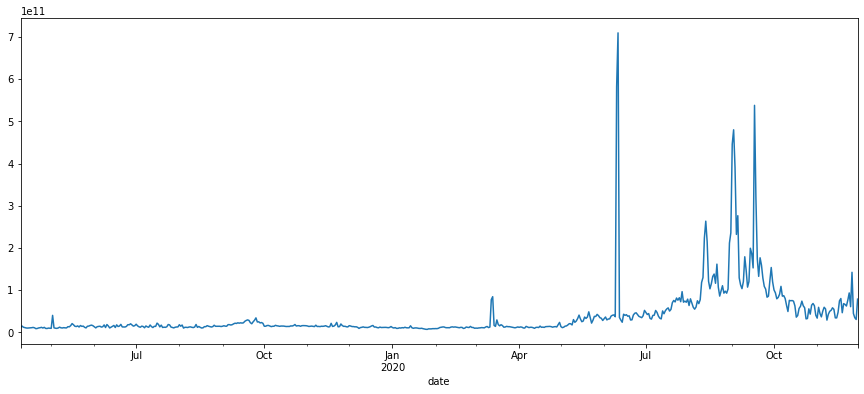

In [8]:
gas_plot = filter_series(df=gas, slice1=FIRST_SLICE_DATE, slice2=THIRD_SLICE_DATE)
gas_plot['gasValue'].plot(figsize = (15, 6))
plt.show()

## Splitting the series

We can see there is two-stage in the series. The first stage ends around May first of 2020, from then the series changed. So let's split the series into two slices. 

In [9]:
gas_slice2 = filter_series(df=gas, slice1=SECOND_SLICE_DATE, slice2=THIRD_SLICE_DATE)

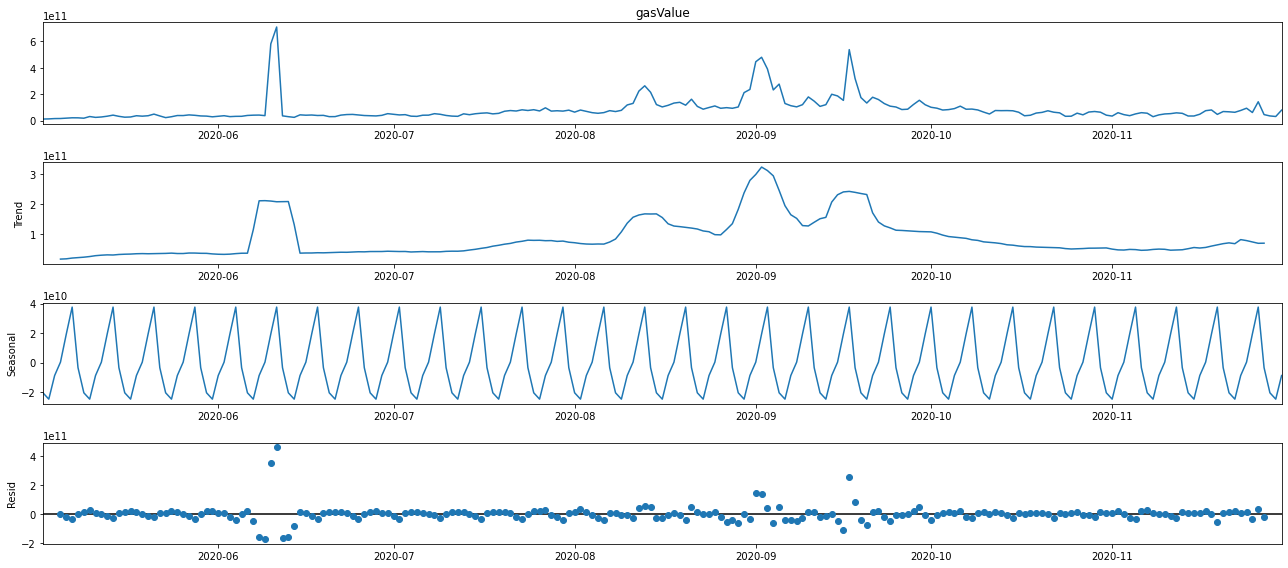

In [10]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x=gas_slice2['gasValue'], model='additive')
fig = decomposition.plot()
plt.show()

Let's apply a log transformation to reduce higher gasValue, and also remove the weekly seasonality.

In [11]:
gas_slice2['gasValue'] = gas_slice2['gasValue']  - decomposition.seasonal
gas_slice2.dropna(inplace=True)

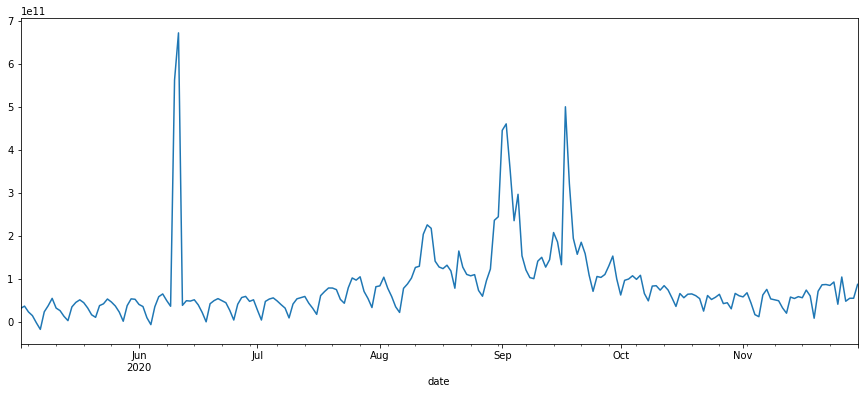

In [12]:
gas_slice2['gasValue'].plot(figsize = (15, 6))
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [13]:
print_adf(df=gas_slice2, key='gasValue')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.625740
P-Value                   0.000116
# Lags Used               2.000000
# Observations Used     210.000000
Critical Value (1%)      -3.461879
Critical Value (5%)      -2.875404
Critical Value (10%)     -2.574159
dtype: float64


In both cases, we can reject the null hypothesis with all the confidence intervals. So, both series haven't a unit root. Hence, they are stationary series.

To confirm that, we are going to perform the kpss test for cross-validation.

## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [14]:
print_kpss(df=gas_slice2, key='gasValue')

KPSS Statistic: 0.3958344497148105
p-value: 0.07895066822637478
num lags: 8
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


In both cases, p-gasValue are greater than 0.05, and "KPSS Statistic" gasValue are less than the critical gasValue. So, we fail to reject H0, and because of that, we confirm that both series are stationary.

# DAOstack activity-membership rate series

Let's check the series.

In [15]:
daostack: pd.DataFrame = pd.read_csv(os.path.join('..', '..', 'data', 'daostack_activity_membership_rate.csv'), header=0)
daostack = transform_date_series(df=daostack, date_key='date')

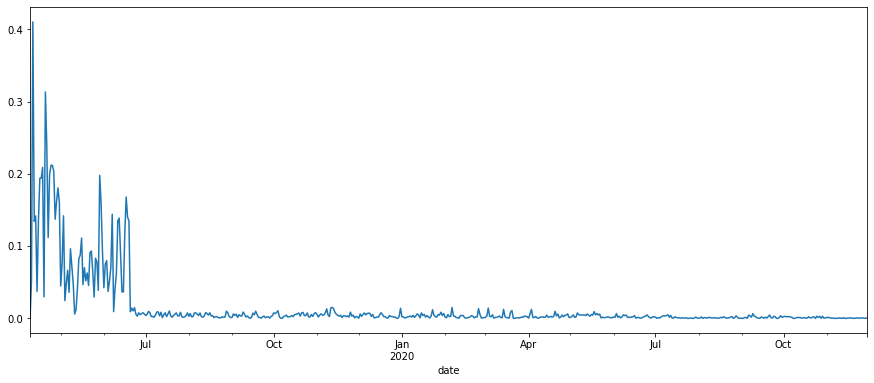

In [16]:
daostack_plot = filter_series(df=daostack, slice1=FIRST_SLICE_DATE, slice2=THIRD_SLICE_DATE)
daostack_plot['rateActionsMembers'].plot(figsize = (15, 6))
plt.show()

## Spliting the series

As we previously do with the gas series, let's split the series.

In [17]:
daostack_slice2 = filter_series(df=daostack, slice1=SECOND_SLICE_DATE, slice2=THIRD_SLICE_DATE)

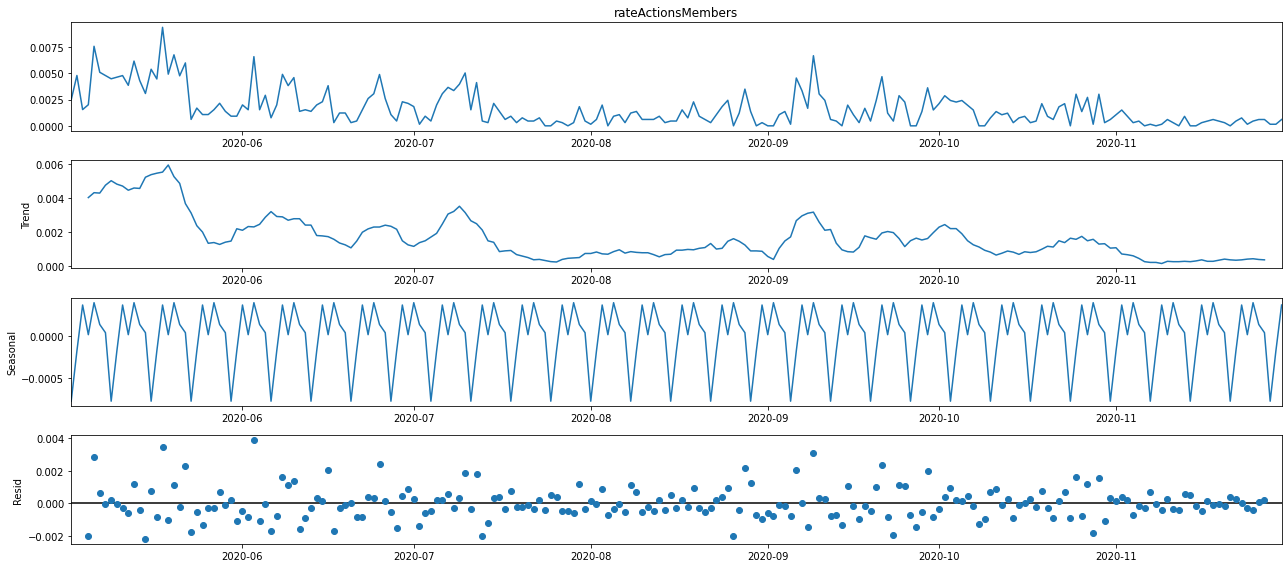

In [18]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x=daostack_slice2['rateActionsMembers'], model='additive')
fig = decomposition.plot()
plt.show()

In [19]:
daostack_slice2['rateActionsMembers'] = daostack_slice2['rateActionsMembers'] - decomposition.seasonal
daostack_slice2.dropna(inplace=True)

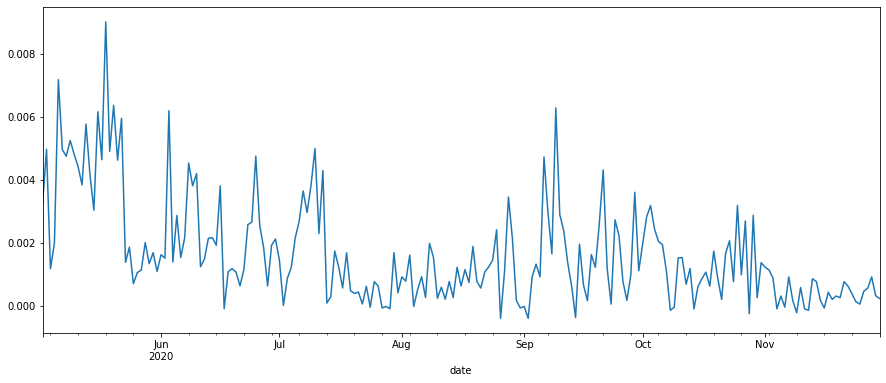

In [20]:
daostack_slice2['rateActionsMembers'].plot(figsize = (15, 6))
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [21]:
print_adf(df=daostack_slice2, key='rateActionsMembers')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -2.576334
P-Value                   0.097988
# Lags Used              11.000000
# Observations Used     201.000000
Critical Value (1%)      -3.463309
Critical Value (5%)      -2.876029
Critical Value (10%)     -2.574493
dtype: float64


In the first series, either p-value or statistic value are lower than all the confidence and critical gasValue. In the second case, its p-value is slower than the 0.05 confidence interval. Those results suggest that we can reject H0 in favor of H1, in other words, both series are stationary.

## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [23]:
print_kpss(df=daostack_slice2, key='rateActionsMembers')

KPSS Statistic: 1.1463119689654464
p-value: 0.01
num lags: 8
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Both series have gasValue that suggest that we fail to reject H0. So, it is definitely a stationary series.

## Phillips–Perron (PP) test

In [38]:
pptest = pm.arima.PPTest()
pptest.should_diff(daostack_slice2['rateActionsMembers'])

(0.01, False)

# Granger Causality Tests

Where:

    * H0: The second column, x2, does NOT Granger cause the time series in the first column, x1
    * H1: x2 Granger cause x1

In [37]:
slice2: pd.DataFrame = pd.DataFrame(
    {'rateActionsMembers': daostack_slice2['rateActionsMembers'].tolist(),
     'gasValue': gas_slice2['gasValue'].tolist(),
    })
    
gc_res2 = grangercausalitytests(slice2, 10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4068  , p=0.2369  , df_denom=209, df_num=1
ssr based chi2 test:   chi2=1.4270  , p=0.2323  , df=1
likelihood ratio test: chi2=1.4222  , p=0.2330  , df=1
parameter F test:         F=1.4068  , p=0.2369  , df_denom=209, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9521  , p=0.3876  , df_denom=206, df_num=2
ssr based chi2 test:   chi2=1.9504  , p=0.3771  , df=2
likelihood ratio test: chi2=1.9415  , p=0.3788  , df=2
parameter F test:         F=0.9960  , p=0.3711  , df_denom=206, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6298  , p=0.1836  , df_denom=203, df_num=3
ssr based chi2 test:   chi2=5.0580  , p=0.1676  , df=3
likelihood ratio test: chi2=4.9981  , p=0.1719  , df=3
parameter F test:         F=1.6093  , p=0.1884  , df_denom=203, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6234  , p=0.1698  

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# VAR analysis

In [25]:
slice2: pd.DataFrame = gas_slice2.copy(deep=True)
slice2['rateActionsMembers'] = daostack_slice2['rateActionsMembers'].tolist()

In [26]:
model2 = sm.tsa.VAR(slice2)
model2.select_order(10).summary()

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,37.53,37.56,1.992e+16,37.54
1,36.61,36.71,7.963e+15,36.65
2,36.50,36.66*,7.112e+15,36.57
3,36.45*,36.68,6.789e+15*,36.55*
4,36.47,36.77,6.929e+15,36.59
5,36.51,36.87,7.193e+15,36.66
6,36.54,36.97,7.413e+15,36.71
7,36.56,37.05,7.580e+15,36.76
8,36.57,37.13,7.648e+15,36.80
9,36.48,37.10,6.998e+15,36.73


In [27]:
results2 = model2.fit(maxlags=3, ic='aic')
results2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 06, Jan, 2021
Time:                     19:40:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    36.7120
Nobs:                     210.000    HQIC:                   36.5791
Log likelihood:          -4413.29    FPE:                7.02975e+15
AIC:                      36.4889    Det(Omega_mle):     6.58353e+15
--------------------------------------------------------------------
Results for equation gasValue
                                 coefficient            std. error           t-stat            prob
---------------------------------------------------------------------------------------------------
const                     26073971141.433407     9431747281.255022            2.764           0.006
L1.gasValue                         0.771125              0.068357           11.2

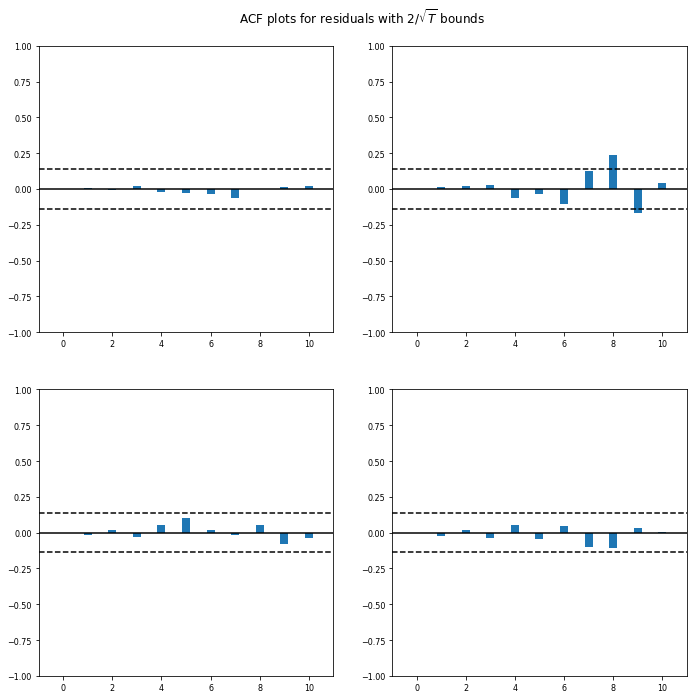

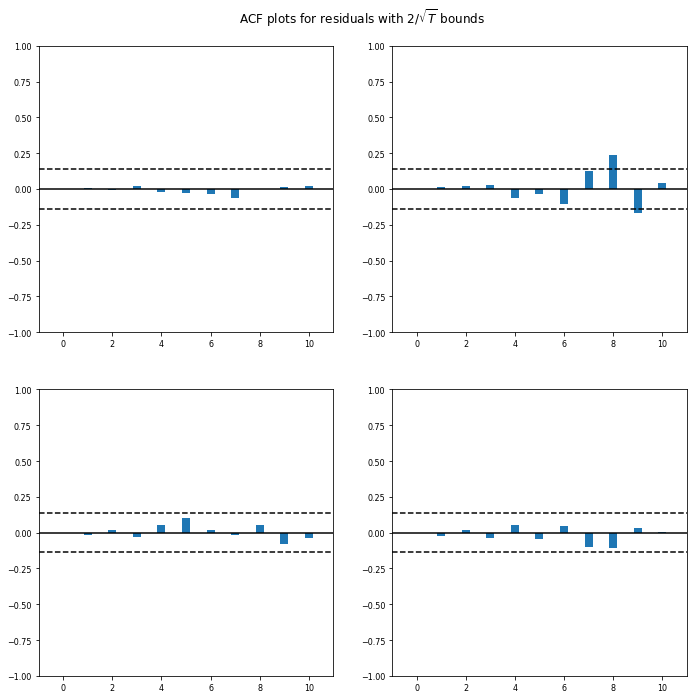

In [28]:
results2.plot_acorr()

### Impulse Response

In [29]:
irf2 = results2.irf(20)

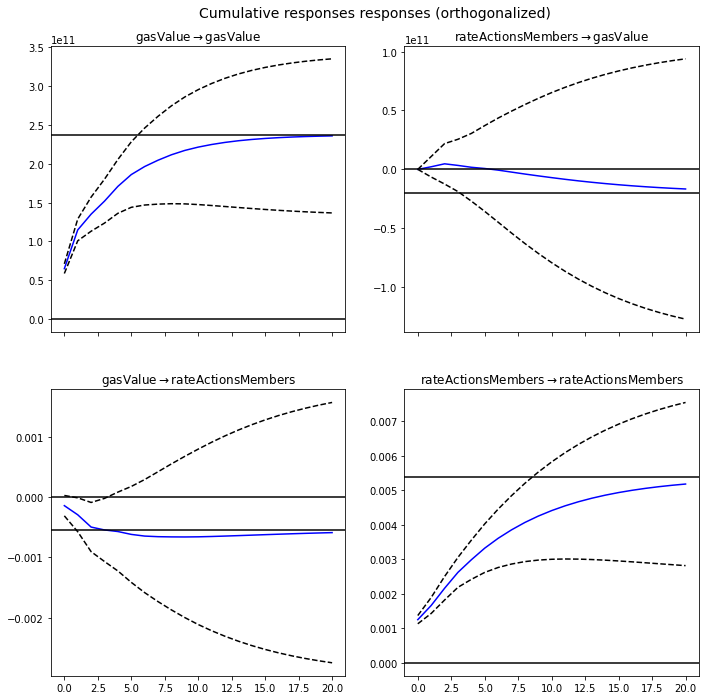

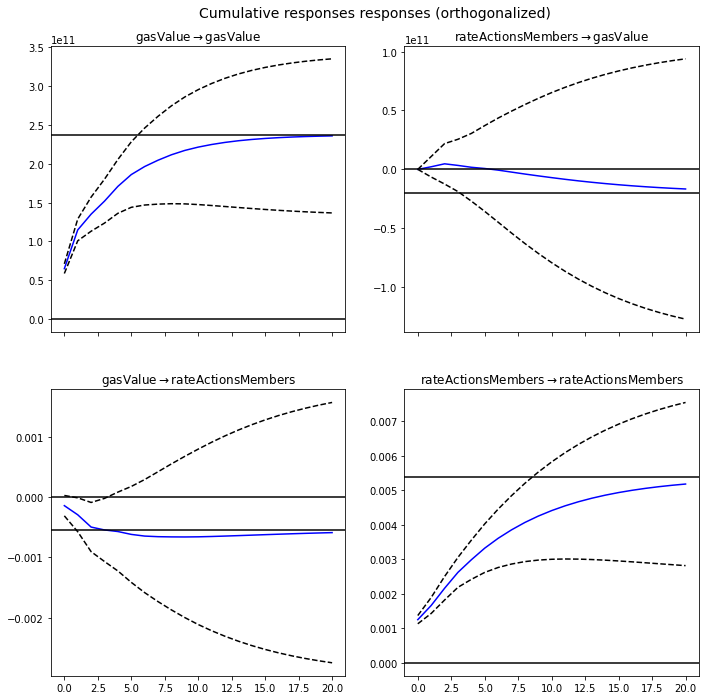

In [30]:
irf2.plot_cum_effects(orth=True)

In [31]:
results2.fevd(periods=20).summary()

FEVD for gasValue
      gasValue  rateActionsMembers
0     1.000000            0.000000
1     0.999274            0.000726
2     0.998435            0.001565
3     0.998244            0.001756
4     0.998007            0.001993
5     0.997932            0.002068
6     0.997723            0.002277
7     0.997404            0.002596
8     0.997087            0.002913
9     0.996804            0.003196
10    0.996544            0.003456
11    0.996306            0.003694
12    0.996100            0.003900
13    0.995929            0.004071
14    0.995786            0.004214
15    0.995668            0.004332
16    0.995573            0.004427
17    0.995498            0.004502
18    0.995437            0.004563
19    0.995390            0.004610

FEVD for rateActionsMembers
      gasValue  rateActionsMembers
0     0.012322            0.987678
1     0.024007            0.975993
2     0.040878            0.959122
3     0.038018            0.961982
4     0.036207            0.963793
5     0.

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
results2.test_normality().summary()

Test statistic,Critical value,p-value,df
7417.,9.488,0.000,4


In [33]:
results2.test_whiteness(nlags=10).summary()

Test statistic,Critical value,p-value,df
36.22,41.34,0.137,28


In [34]:
results2.test_inst_causality(causing='gasValue').summary()

Test statistic,Critical value,p-value,df
2.556,3.841,0.110,1


In [35]:
results2.test_causality(caused='rateActionsMembers',causing='gasValue').summary()

Test statistic,Critical value,p-value,df
1.564,2.627,0.198,"(3, 406)"
